In [1]:
!cd "matlabroot/extern/engines/python"
!matlabroot

/bin/sh: line 0: cd: matlabroot/extern/engines/python: No such file or directory
/bin/sh: matlabroot: command not found


In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import math
import random

## GL algorithm 

In [3]:
import matlab.engine
eng = matlab.engine.start_matlab()
eng.addpath(r'./gl', nargout=0)

In [4]:
df = pd.read_csv('diuretic_filtered_data.csv')

In [5]:
df.sort_values(by=['icustay_id','hour'], inplace=True)

ids = df["icustay_id"].unique().tolist()

In [16]:
len(df[["mv", "amount_binary", "vaso_binary", "death_2", "release"]]) - df[["mv", "amount_binary", "vaso_binary", "death_2", "release"]].count()

mv               0
amount_binary    0
vaso_binary      0
death_2          0
release          0
dtype: int64

In [6]:
np.random.seed(1)
np.random.shuffle(ids)



total_num_patients = len(ids)
num_train = math.floor(total_num_patients*0.6)
num_val = math.floor(total_num_patients*0.2)

In [7]:
def normalize(ddf, settings=None):
    
    new_settings = dict()
    
    all_cols = ddf.columns[2:]
    newdf = pd.DataFrame()
    newdf['icustay_id'] = ddf['icustay_id']
    newdf['hour'] = ddf['hour']
    cols_to_norm = ["baseexcess", "bicarbonate", "totalco2", \
                     "hemoglobin", "lactate", "so2", "pco2", "ph", "po2", "potassium", "bun",\
                     "bilirubin", "creatinine", "platelet", "urineoutput", "heartrate", \
                     "sysbp", "diasbp", "meanbp", "resprate", "tempc", "spo2", "weight",
                     "gcs", "gcsmotor", "gcsverbal", "gcseyes",\
                     "amount", "gender", "age","pre_icu_fluid"]
    
    
    

    for c in cols_to_norm: 
        if c not in ['Pth']:
            x = ddf[c].values.tolist() # df[c].values.tolist()
            #print(x[0])

            A = matlab.double(x)[0]
            A = eng.transpose(A)
            if settings is None:
                B, S = eng.glscale(A, nargout=2)
                new_settings.update({c:np.array(S).ravel().tolist()})
            else : 
                B = eng.glscale(A, eng.transpose(matlab.double(settings[c])[0]))
            newdf[c] = np.array(B)
        else:
            newdf[c] = 0

    for c in list(set(all_cols) - set(cols_to_norm)): 
        newdf[c] = ddf[c]
    
    return newdf, new_settings

In [8]:
icustay_ids = df['icustay_id'].unique()
np.random.seed(1)
np.random.shuffle(icustay_ids)

total_num_patients = len(icustay_ids)
num_train = int(math.floor(0.6*total_num_patients))
num_val = int(math.floor(0.2*total_num_patients))

train_ids = icustay_ids[:num_train]
val_ids = icustay_ids[num_train:(num_train+num_val)]
test_ids = icustay_ids[(num_train+num_val):]

In [9]:
cols_to_norm = ["baseexcess", "bicarbonate", "totalco2", \
                     "hemoglobin", "lactate", "so2", "pco2", "ph", "po2", "potassium", "bun",\
                     "bilirubin", "creatinine", "platelet", "urineoutput", "heartrate", \
                     "sysbp", "diasbp", "meanbp", "resprate", "tempc", "spo2", "weight",
                     "gcs", "gcsmotor", "gcsverbal", "gcseyes",\
                     "amount", "age","pre_icu_fluid"]

print(df[cols_to_norm].quantile(1))

for i in cols_to_norm:
    if i not in df.columns.tolist():
        print(i)

baseexcess          24.00000
bicarbonate         37.00000
totalco2            61.00000
hemoglobin          17.40000
lactate             32.00000
so2                100.00000
pco2               132.00000
ph                   7.71000
po2                587.00000
potassium            7.40000
bun                141.00000
bilirubin           47.90000
creatinine          18.10000
platelet          1592.00000
urineoutput       4000.00000
heartrate          211.00000
sysbp              269.00000
diasbp             226.00000
meanbp             299.00000
resprate            68.00000
tempc               40.83333
spo2               100.00000
weight             894.00000
gcs                 15.00000
gcsmotor             6.00000
gcsverbal            5.00000
gcseyes              4.00000
amount            6545.81900
age                 92.00000
pre_icu_fluid    10000.00000
Name: 1, dtype: float64


In [10]:
train_df = df[df['icustay_id'].isin(train_ids)]

val_df = df[df['icustay_id'].isin(val_ids)]

test_df = df[df['icustay_id'].isin(test_ids)]

print(test_df.index)
train_df, settings = normalize(train_df)

print("done training")
print(settings)

#val_df, _ = normalize(df[df['icustay_id'].isin(val_ids)], settings)
#test_df, _ = normalize(df[df['icustay_id'].isin(test_ids)], settings)

Int64Index([    51,     52,     53,     54,     55,     56,     57,     58,
                59,     60,
            ...
            322937, 322938, 322939, 322940, 322941, 322942, 322943, 322944,
            322945, 322946],
           dtype='int64', length=64338)
done training
{'resprate': [0.23677205039379964, 14.752953386475218, 0.23891234298262756, 0.14530852892000257], 'tempc': [1.8925412241392208, 39.52084689168325, 0.0008596115129028191, 0.2582048841359943], 'heartrate': [0.07015462958476465, 78.2701097056388, 0.31051775293467504, 0.29739642937271393], 'weight': [0.01564115310814728, 58.0826568298413, 0.056900879819676016, 0.1359864737393271], 'bicarbonate': [0.047358121061537695, -45.096411619999124, 0.9621362354851926, 1.0156126126463356], 'hemoglobin': [0.03691043951841437, -43.361312094353835, 0.4486562577208318, 0.5448195551250824], 'potassium': [0.034262461455434434, -39.77155278772189, 0.44647175707641423, 0.5435001671877334], 'sysbp': [0.0612649439375468, 113.48818579906

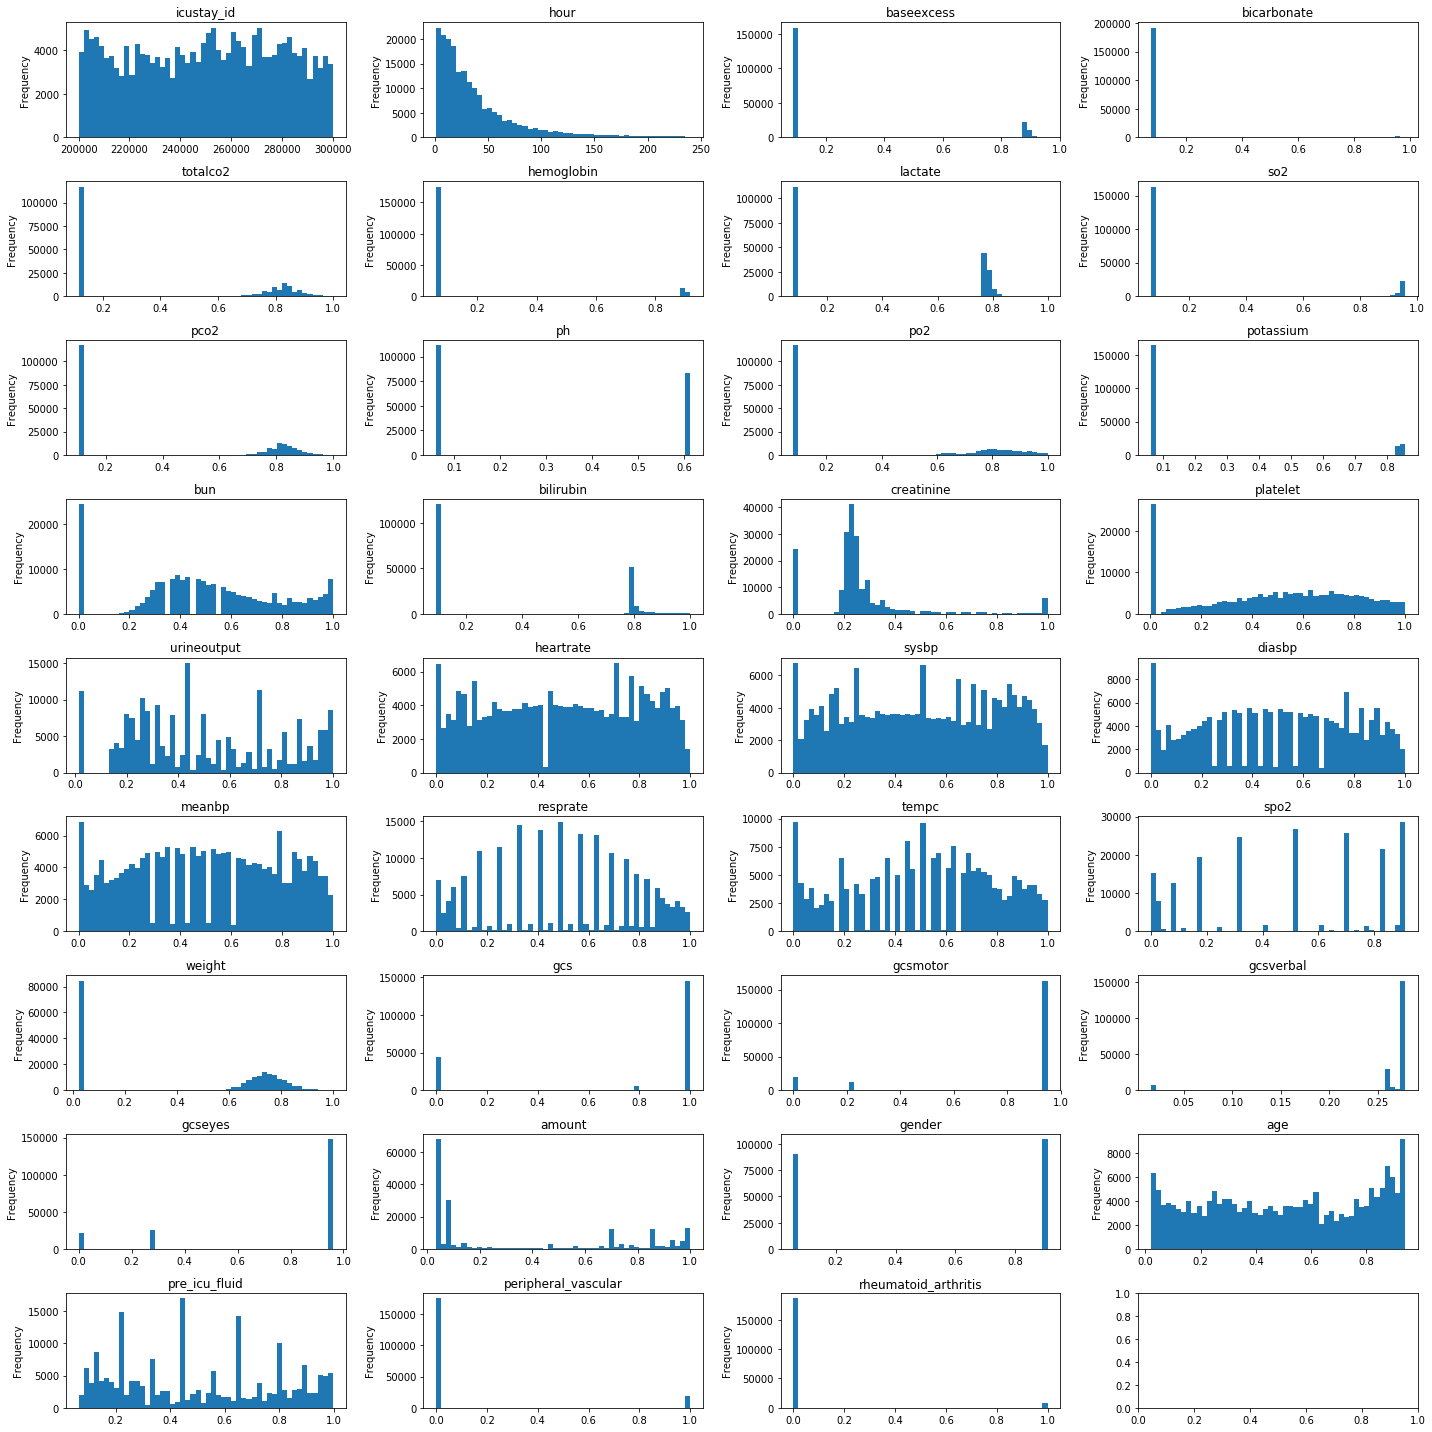

In [12]:
fig, axX = plt.subplots(9, 4, figsize=(20, 20))

for idx in range(35):
    ax = axX.flatten()[idx]
    train_df.iloc[:, idx].plot.hist(ax=ax, bins=50)
    ax.set_title(train_df.columns[idx])
fig.tight_layout()

In [13]:
val_df, _ = normalize(df[df['icustay_id'].isin(val_ids)], settings)
test_df, _ = normalize(df[df['icustay_id'].isin(test_ids)], settings)

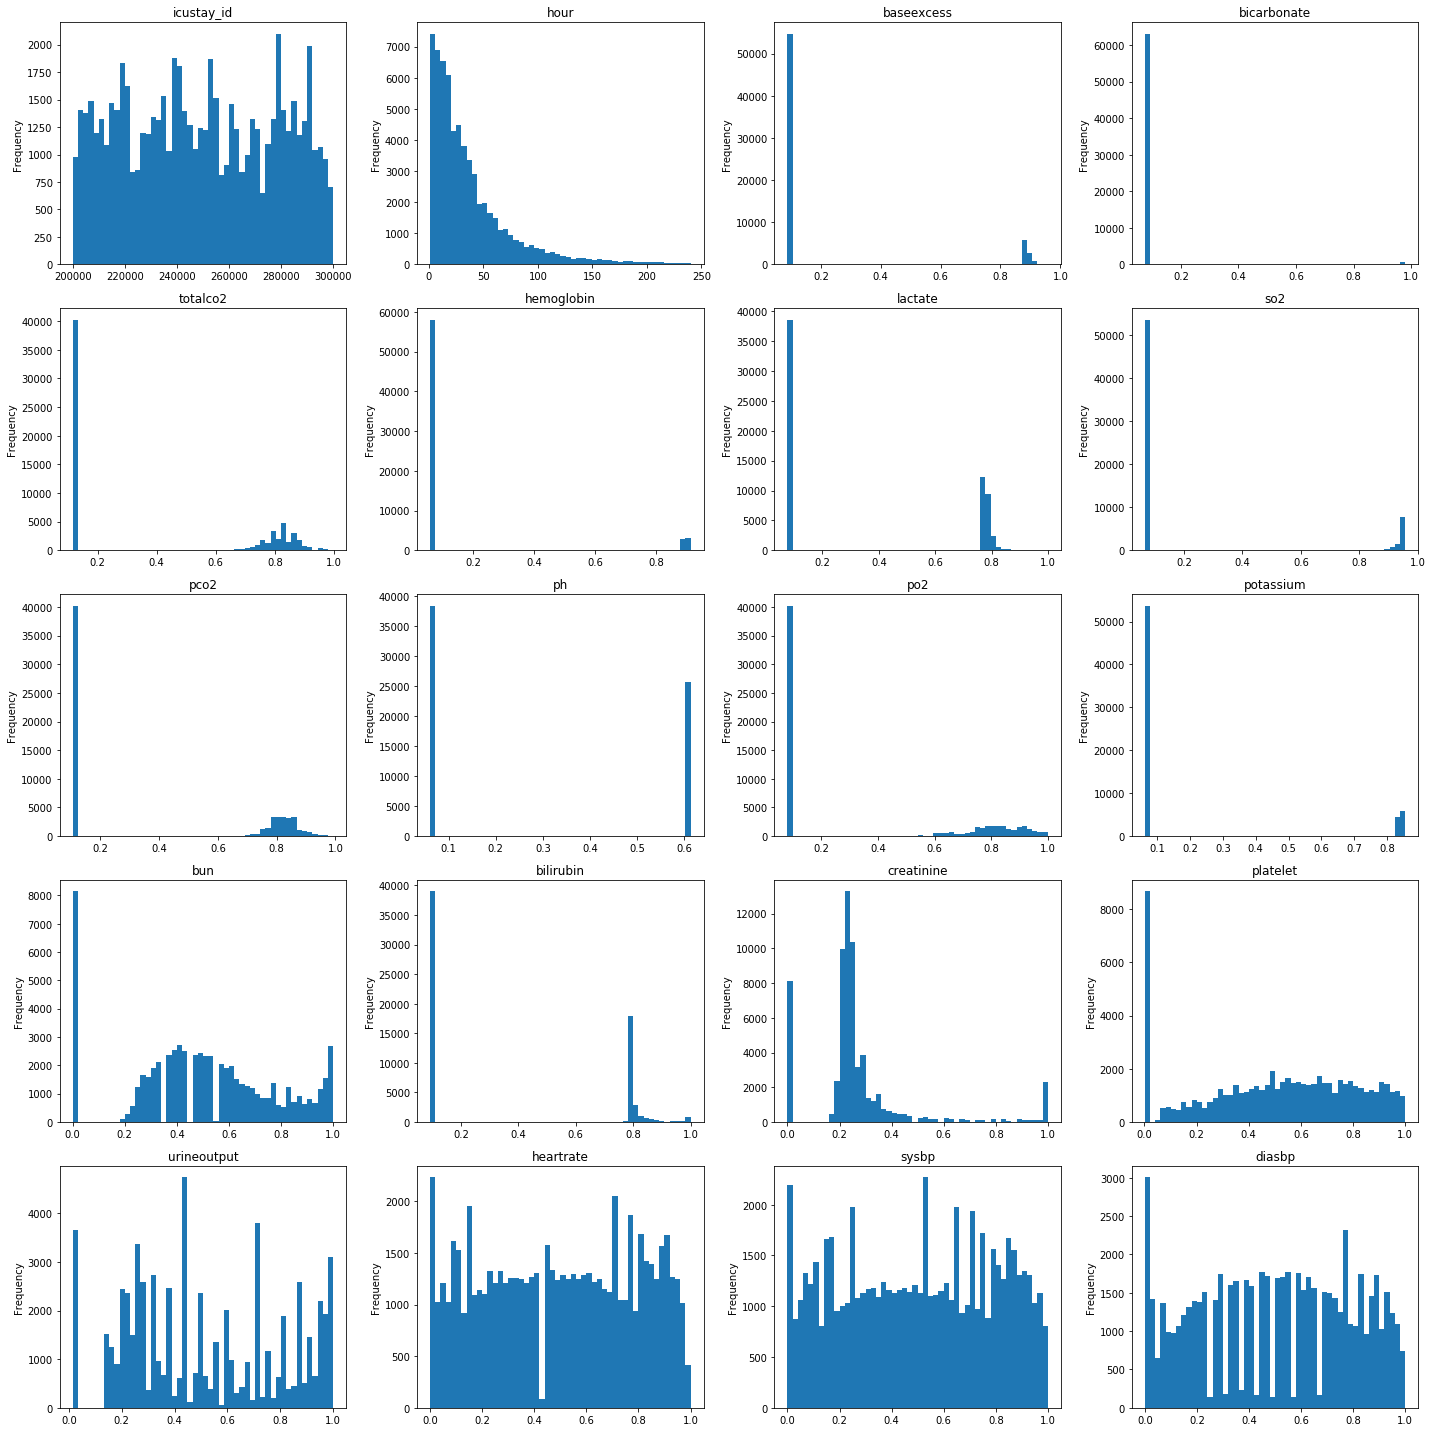

In [14]:
fig, axX = plt.subplots(5, 4, figsize=(20, 20))

for idx in range(20):
    ax = axX.flatten()[idx]
    val_df.iloc[:, idx].plot.hist(ax=ax, bins=50)
    ax.set_title(val_df.columns[idx])
fig.tight_layout()

In [42]:
newdf = pd.concat([train_df,val_df])
newdf = pd.concat([newdf,test_df])

newdf.sort_values(by=['icustay_id','hour'], inplace=True)
newdf.to_csv('diuretic_filtered_normalized_data_new.csv')

In [17]:
train_df.to_csv('diuretic_filtered_normalized_data_train.csv')
val_df.to_csv('diuretic_filtered_normalized_data_val.csv')
test_df.to_csv('diuretic_filtered_normalized_data_test.csv')

In [32]:
def gl_inv(value, coefficients): 
	(B, M, Q, V) = (coefficients[0], coefficients[1], coefficients[2], coefficients[3])
	# value = max(10**-6, value)
	print("(B, M, Q, V)", (B, M, Q, V))
	print("value", value)
	print("-v", -V)
	print("here", value**(-V))
	print("log stuff", math.log((value**(-V) -1.0)/Q+ 10**-6))
	return M - (1.0/B)*math.log((value**(-V) -1.0)/Q+ 10**-6)

('(B, M, Q, V)', (0.052378071450726274, -38.954325178161355, 1.9027059101345574, 1.5928749160057922))
('value', 0.088519)
('-v', -1.5928749160057922)
('here', 47.55970456008625)
('log stuff', 3.197458462667534)


-100.00007150113328

In [35]:
print(len(newdf))

newdf.quantile(q=1)

2770213


icustay_id                  299999.000000
hour                           240.000000
baseexcess                       0.999999
bicarbonate                      0.999813
totalco2                         0.999999
hemoglobin                       0.999945
lactate                          1.000000
so2                              0.851983
pco2                             0.999999
ph                               0.999999
po2                              0.999665
potassium                        1.000000
bun                              0.997486
bilirubin                        1.000000
creatinine                       1.000000
platelet                         1.000000
urineoutput                      1.000000
heartrate                        0.998267
sysbp                            0.999518
diasbp                           0.999997
meanbp                           0.999994
resprate                         0.999994
tempc                            0.999952
spo2                             0

In [7]:
settings = {'RVC': [5.78690287634746, 1.0418754237870058, 0.3236417828699586, 0.1510759223804095], 'MAP': [0.025712035393314726, 89.07399035572092, 0.07156158525036088, 0.09367975961442494], 'sbp': [0.03243708381543212, 120.05097497885366, 0.06863141837520956, 0.09246955475836585], 'LVQ': [0.022856452871569715, 56.69043136665101, 0.07334257899733536, 0.09257077508800014], 'LVP': [0.023540220034305136, 30.312199702293007, 0.08757260896001666, 0.09265767379051504], 'bolus': [0.08206609851024411, 31.094898386348465, 0.06249544234619732, 0.11123448404336383], 'PVV': [0.01881123010338925, 615.1340542199235, 0.07183193509207958, 0.09214974643977719], 'HR': [0.025814912669470867, 92.50060287957304, 0.08086115990099509, 0.09751673994248679], 'vasopressor': [50.95208389692519, 0.03177463609054187, 0.047704110505353975, 0.040041465888197514], 'CVP': [0.1511613675066818, 18.294531320130176, 0.05638504270639723, 0.0881952732680958], 'TBV': [0.0011023950106822584, 3469.5498698530355, 0.4509194924564419, 0.5675122777820917], 'AQ': [0.01866775012932929, 112.91929212516152, 0.06821564273951039, 0.09496733117653522], 'AP': [0.037154441946863015, 85.01869062775296, 0.068227703094287, 0.09548931890494805], 'RVQ': [0.019252471540665297, 102.33556701753635, 0.06480473481115971, 0.09202325201942138], 'RVP': [0.023668784446582554, 24.22874529363017, 0.09057534730995985, 0.09090859622754292], 'VT': [0.00485693188748258, 2509.076695957147, 0.5235751502725721, 0.4191173135136524], 'LVC': [8.622382203366632, 0.21439599229880948, 0.3162967130171071, 0.13343835789047184], 'AV': [0.03915636332983899, 778.9505353273981, 0.06845410299374213, 0.09719786707568116], 'AR': [5.153344615217181, 0.5352571177377783, 0.06707509588837819, 0.08935329060746153]}

print(settings)

test_1 = pd.read_csv("../downloads/6c_testing_no_tx_filtered_1_2_1000.csv")
#test_2 = pd.read_csv("../downloads/6c_testing_filtered_1_3_1000.csv")



{'RVC': [5.78690287634746, 1.0418754237870058, 0.3236417828699586, 0.1510759223804095], 'MAP': [0.025712035393314726, 89.07399035572092, 0.07156158525036088, 0.09367975961442494], 'sbp': [0.03243708381543212, 120.05097497885366, 0.06863141837520956, 0.09246955475836585], 'LVQ': [0.022856452871569715, 56.69043136665101, 0.07334257899733536, 0.09257077508800014], 'LVP': [0.023540220034305136, 30.312199702293007, 0.08757260896001666, 0.09265767379051504], 'bolus': [0.08206609851024411, 31.094898386348465, 0.06249544234619732, 0.11123448404336383], 'PVV': [0.01881123010338925, 615.1340542199235, 0.07183193509207958, 0.09214974643977719], 'HR': [0.025814912669470867, 92.50060287957304, 0.08086115990099509, 0.09751673994248679], 'CVP': [0.1511613675066818, 18.294531320130176, 0.05638504270639723, 0.0881952732680958], 'TBV': [0.0011023950106822584, 3469.5498698530355, 0.4509194924564419, 0.5675122777820917], 'AQ': [0.01866775012932929, 112.91929212516152, 0.06821564273951039, 0.09496733117653

In [141]:
print(settings)

{'RVC': [5.78690287634746, 1.0418754237870058, 0.3236417828699586, 0.1510759223804095], 'MAP': [0.025712035393314726, 89.07399035572092, 0.07156158525036088, 0.09367975961442494], 'sbp': [0.03243708381543212, 120.05097497885366, 0.06863141837520956, 0.09246955475836585], 'LVQ': [0.022856452871569715, 56.69043136665101, 0.07334257899733536, 0.09257077508800014], 'LVP': [0.023540220034305136, 30.312199702293007, 0.08757260896001666, 0.09265767379051504], 'bolus': [0.08206609851024411, 31.094898386348465, 0.06249544234619732, 0.11123448404336383], 'PVV': [0.01881123010338925, 615.1340542199235, 0.07183193509207958, 0.09214974643977719], 'HR': [0.025814912669470867, 92.50060287957304, 0.08086115990099509, 0.09751673994248679], 'vasopressor': [50.95208389692519, 0.03177463609054187, 0.047704110505353975, 0.040041465888197514], 'CVP': [0.1511613675066818, 18.294531320130176, 0.05638504270639723, 0.0881952732680958], 'TBV': [0.0011023950106822584, 3469.5498698530355, 0.4509194924564419, 0.567

In [8]:
test_1, _ = normalize(test_1, settings)

#test_2, _ = normalize(test_2, settings)


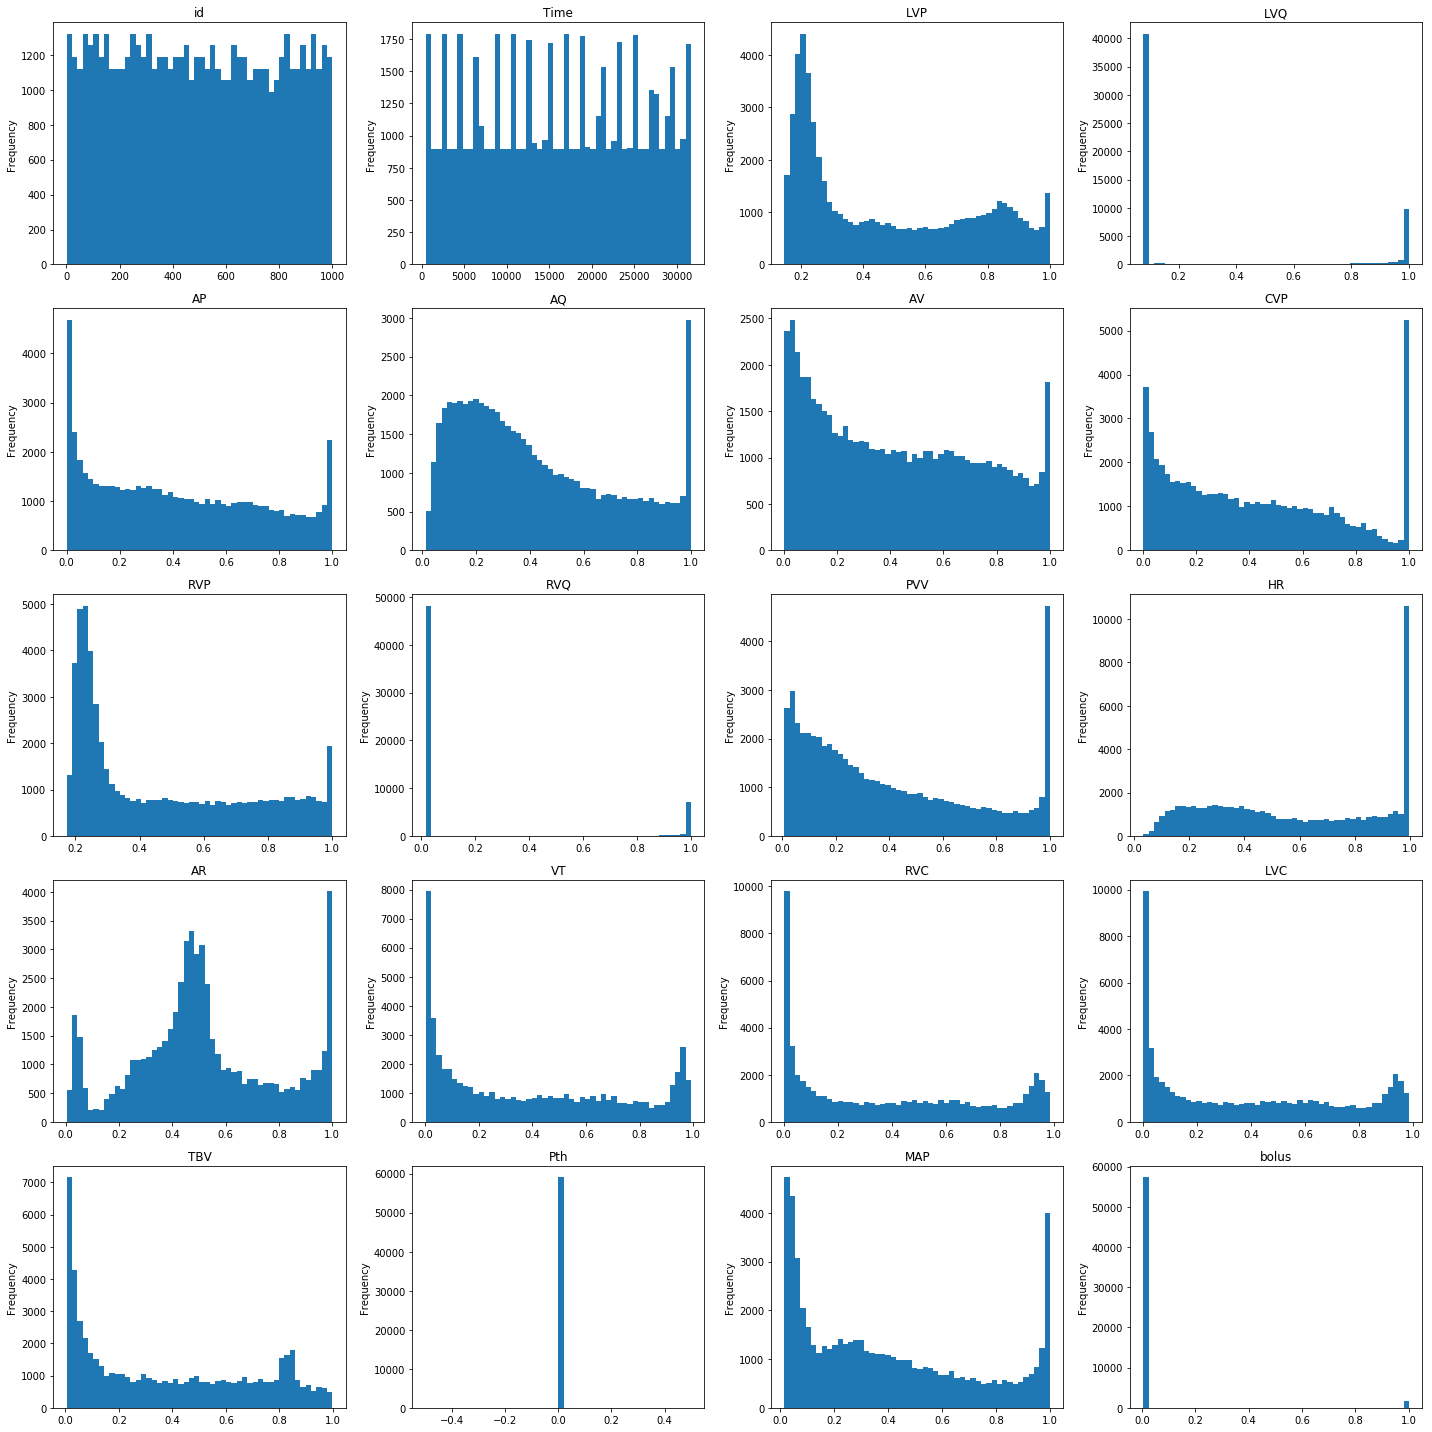

In [9]:
fig, axX = plt.subplots(5, 4, figsize=(20, 20))

for idx in range(20):
    ax = axX.flatten()[idx]
    test_1.iloc[:, idx].plot.hist(ax=ax, bins=50)
    ax.set_title(test_1.columns[idx])
fig.tight_layout()

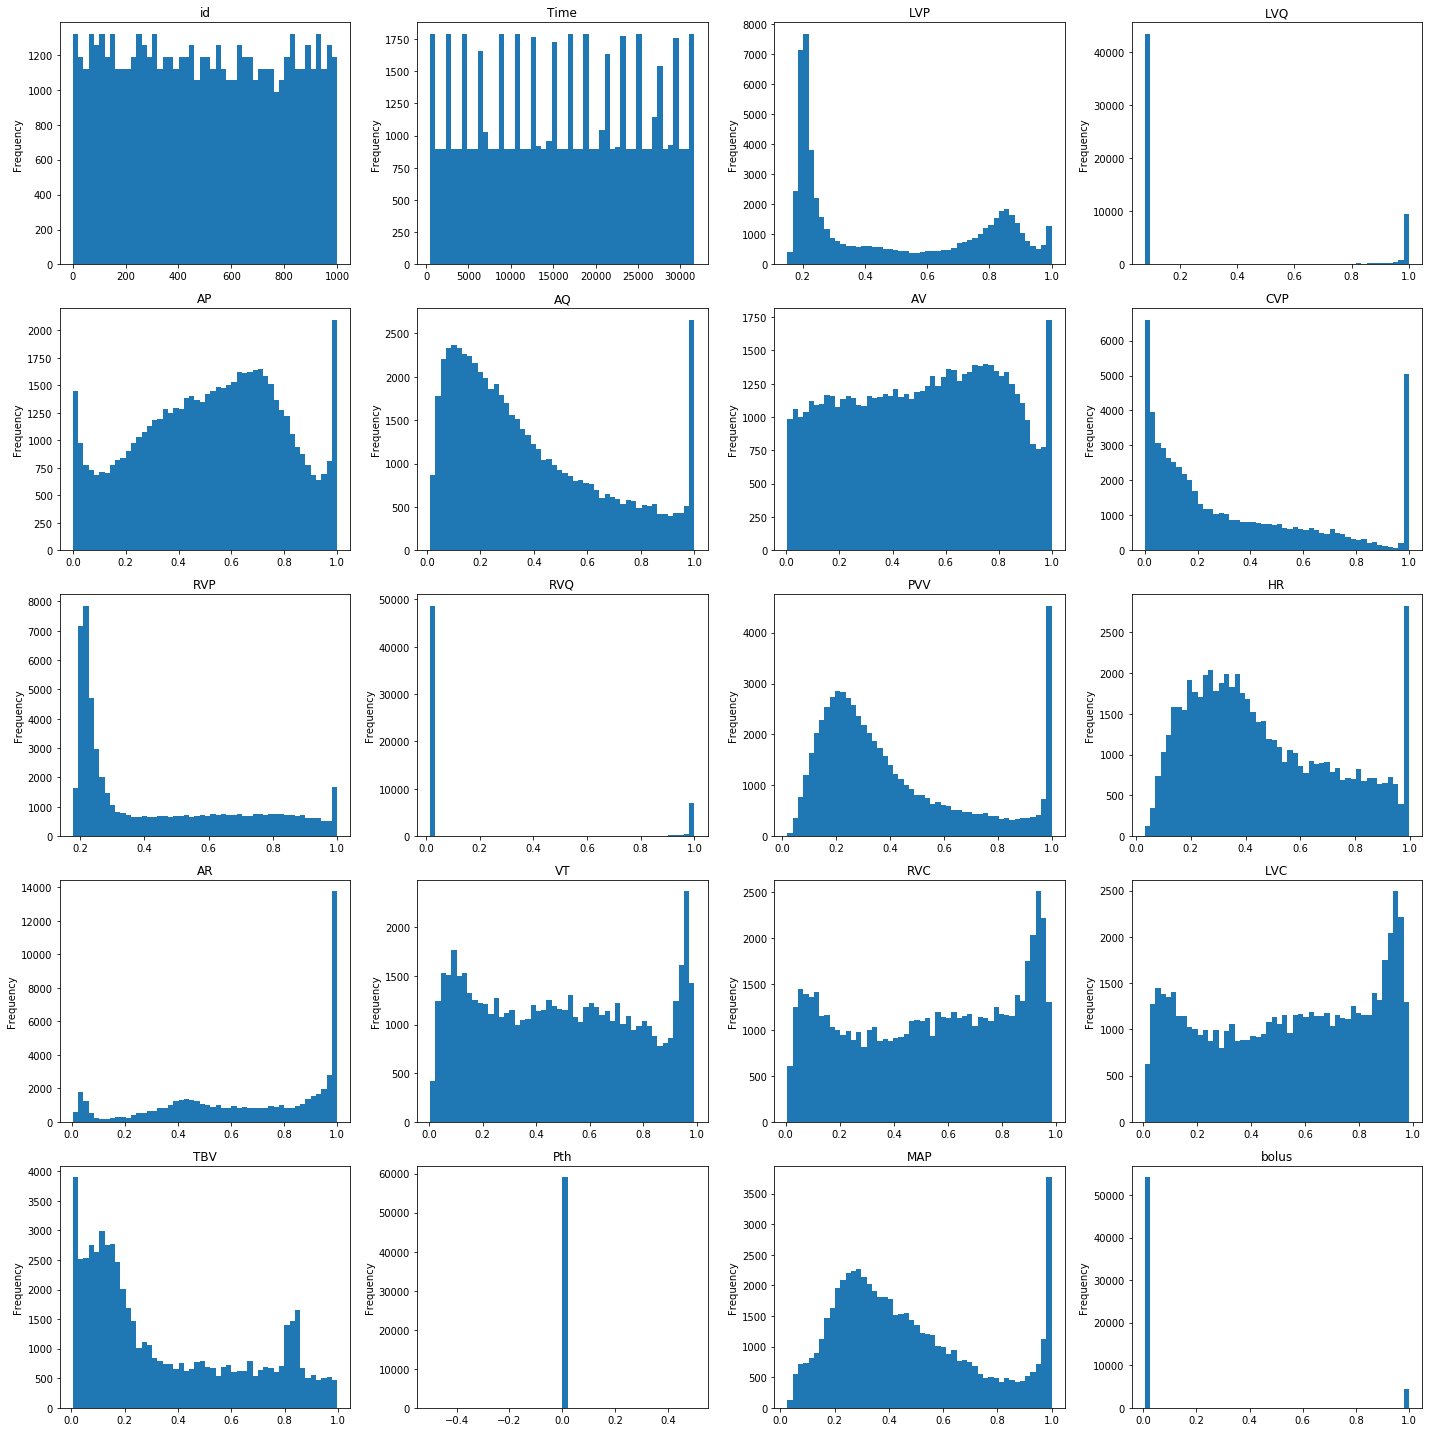

In [17]:
fig, axX = plt.subplots(5, 4, figsize=(20, 20))

for idx in range(20):
    ax = axX.flatten()[idx]
    test_2.iloc[:, idx].plot.hist(ax=ax, bins=50)
    ax.set_title(test_2.columns[idx])
fig.tight_layout()

In [10]:
test_1.to_csv("../downloads/6c_testing_1_2_normalized_no_tx.csv")
#test_2.to_csv("../downloads/6c_testing_1_3_normalized_.csv")

In [19]:
cols_to_norm = ["LVP", "LVQ","AP", "AQ", "AV", "CVP", "RVP", "RVQ", 
                    "PVV", "HR", "AR", "VT", "RVC", "LVC", "TBV", "Pth",
                    "MAP", "bolus", "vasopressor", "sbp"]



for i in cols_to_norm:
    if (test_1[i] > 1.0).any() or (test_2[i] > 1.0).any():
        print(test_1[i])

In [20]:
test_2[cols_to_norm].describe()

,LVP,LVQ,AP,AQ,AV,CVP,RVP,RVQ,PVV,HR,AR,VT,RVC,LVC,TBV,Pth,MAP,bolus,vasopressor,sbp
count,59070.000000,59070.000000,59070.000000,59070.000000,59070.000000,59070.000000,59070.000000,59070.000000,59070.000000,59070.000000,59070.000000,59070.000000,59070.000000,59070.000000,59070.000000,59070.0,59070.000000,59070.000000,59070.000000,59070.000000
mean,0.480844,0.291419,0.523618,0.381493,0.512573,0.318808,0.449569,0.169407,0.409002,0.464930,0.673967,0.490666,0.533517,0.533438,0.351312,0.0,0.468042,0.084222,0.084372,0.467674
std,0.286656,0.373115,0.266970,0.276860,0.280096,0.310405,0.261227,0.346110,0.272570,0.260430,0.306210,0.293470,0.298859,0.298888,0.295324,0.0,0.261946,0.267147,0.269970,0.257117
min,0.151584,0.076940,0.000300,0.012327,0.003770,0.000059,0.177550,0.015796,0.019771,0.031978,0.004470,0.003199,0.006663,0.006063,0.005329,0.0,0.026151,0.005024,0.004569,0.000009
25%,0.211743,0.076940,0.320375,0.155845,0.272797,0.068177,0.222373,0.015796,0.204523,0.255024,0.436812,0.226083,0.262846,0.263095,0.107382,0.0,0.263874,0.005024,0.004569,0.284184
50%,0.358697,0.076940,0.541745,0.305031,0.526918,0.194757,0.321451,0.015796,0.317754,0.406542,0.742982,0.482024,0.558141,0.558701,0.229738,0.0,0.407527,0.005024,0.004569,0.416908
75%,0.791008,0.378060,0.730035,0.558141,0.749183,0.507762,0.671149,0.015796,0.547487,0.658278,0.973442,0.739478,0.808967,0.808658,0.599176,0.0,0.633086,0.005024,0.004569,0.614593
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.995322,1.000000,0.991453,0.983980,0.983702,0.996977,0.0,1.000000,1.000000,1.000000,1.000000


In [2]:
normalized = pd.read_csv("diuretic_filtered_normalized_data.csv")


In [34]:
a = [normalized.quantile(q=0) < 0]

In [43]:
a[0][65:85]

SICU                     False
aado2                    False
cns_24hours              False
diabetes_complicated     False
hematocrit               False
exclusion_organ_donor    False
coagulation_24hours      False
respiration              False
renal_24hours            False
valvular_disease         False
alcohol_abuse            False
aniongap                 False
rheumatoid_arthritis     False
height                   False
peep                     False
liver_disease            False
temperature              False
pt                       False
deficiency_anemias       False
albumin                  False
Name: 0, dtype: bool